In [1]:
## import modules 

import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import data
from scipy.misc import imresize
from scipy.ndimage.filters import gaussian_filter
import IPython.display as ipyd
import tensorflow as tf
from libs import utils, gif, datasets, dataset_utils, vae, dft, vgg16, nb_utils

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

#### Take a look at google's inception model V3

- the loading process has been codded in lib inception.py file 
- This network has been trained on ImageNet and its finaly output layer is a softmax layer denoting 1 of 1000 possible objects (+ 8 for unknown categories). This network is about only 50MB!

In [2]:
sess = tf.InteractiveSession()

#### 1. load inception model 

In [3]:
## load inception model 
from libs import inception

In [4]:
## load the inception model 
net = inception.get_inception_model()       ## it will download the model from internet
                                            ## you can actually specify version here e.g :
                                            # net = inception.get_inception_model(version='v3')
                                            # net = vgg16.get_vgg_model()
                                            # net = vgg16.get_vgg_face_model()
                                            # net = i2v.get_i2v_model()
                                            # net = i2v.get_i2v_tag_model()

In [5]:
### this is all the labels that is pretrained in inception model 
net['labels'][:10]

[(0, 'dummy'),
 (1, 'kit fox'),
 (2, 'English setter'),
 (3, 'Siberian husky'),
 (4, 'Australian terrier'),
 (5, 'English springer'),
 (6, 'grey whale'),
 (7, 'lesser panda'),
 (8, 'Egyptian cat'),
 (9, 'ibex')]

In [6]:
## now let's take a look at the graph 
tf.import_graph_def(net['graph_def'], name='inception')   ## set the default graph to be inception graph 
g = tf.get_default_graph()

## use nb_utils to visualize graph, there is a whole section on how to use tensorflow board 
## you can look into it further 
nb_utils.show_graph(net['graph_def'])

#### 2. get the tensor for input and output 

In [7]:
## print the name of each process in the graph 
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
print(names[:10])

['inception/input', 'inception/conv2d0_w', 'inception/conv2d0_b', 'inception/conv2d1_w', 'inception/conv2d1_b', 'inception/conv2d2_w', 'inception/conv2d2_b', 'inception/mixed3a_1x1_w', 'inception/mixed3a_1x1_b', 'inception/mixed3a_3x3_bottleneck_w']


In [8]:
## use get_tensor_by_name to get the input tensor and the output tensor 
## so that we can use them to do prediction 

input_name = names[0] + ':0'                     ## use name to get to the input tensor, we need to add 0 to the end, 
x = g.get_tensor_by_name(input_name)             ## it is just the way tf works, newly created node will be marked as 0
softmax = g.get_tensor_by_name(names[-1] + ':0') ## use name to ge to the output tensor, the output tensor
## we can name the output tensor whatever we want, 
## here because it is using softmax, so we just name it softmax

#### 3. Use these tensor to predict

0 255


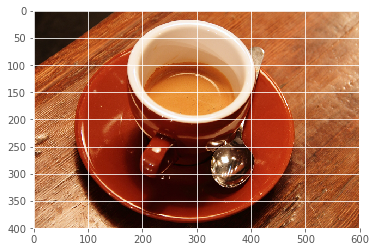

In [9]:
from skimage.data import coffee
og = coffee()              ## from skimage, get coffee picture
plt.imshow(og)
print(og.min(), og.max())  ## pixel value range

In [10]:
# Note that in the lecture, I used a slightly different inception
# model, and this one requires us to subtract the mean from the input image.
# The preprocess function will also crop/resize the image to 299x299
img = inception.preprocess(og)
print(og.shape), print(img.shape)
print(img.min(), img.max())        ## now, what left over is the variance

(400, 600, 3)
(299, 299, 3)
-117.0 138.0


image after preprocess

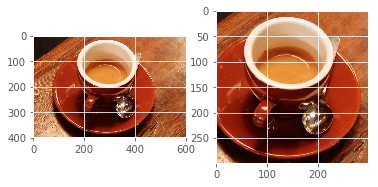

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(og)

# Note that unlike the lecture, we have to call the `inception.deprocess` function
# so that it adds back the mean!
axs[1].imshow(inception.deprocess(img))

- reshape image to 4D 
- As we've seen from the last session, our images must be shaped as a 4-dimensional shape describing the number of images, height, width, and number of channels. So our original 3-dimensional image of height, width, channels needs an additional dimension on the 0th axis.

In [12]:
#### reshape image from 3d to 4 d 
img_4d = img[np.newaxis]         ## this is how you add a dimention 
print(img_4d.shape)

(1, 299, 299, 3)


#### 4. Now we can run the prediction 

In [13]:
## run the predictio using softmax tensor, which is the output tensor, input is img_4d
res = np.squeeze(softmax.eval(feed_dict={x: img_4d}))

In [14]:
# Note that this network is slightly different than the one used in the lecture.
# Instead of just 1 output, there will be 16 outputs of 1008 probabilities.
# We only use the first 1000 probabilities (the extra ones are for negative/unseen labels)
print(res.shape)

## i am not sure why it is giving us 16 outputs, but we can aggregate them 
res = np.mean(res, 0)   ## aggregate accross all 16 outputes 
res = res / np.sum(res) ## np.sum(res) is 16 as we had 16 output,we devided by 16, so we will have a 
                         ## correct confidence percentage

(16, 1008)


In [15]:
## of print the list of resulst, show 5, sort from highest probability to lowest
print([(res[idx], net['labels'][idx]) for idx in res.argsort()[-5:][::-1]])

## res.argsort()[-5:][::-1]  --- 
## res.argsort() will give sort the res data and give you the element index of original res,asending
## [-5:] will get the last 5
## [::-1] will reverse sort the data 

[(0.99849206, (947, 'espresso')), (0.000631253, (859, 'cup')), (0.00050241494, (953, 'chocolate sauce')), (0.00019483209, (844, 'consomme')), (0.00013370356, (822, 'soup bowl'))]


#### 5. Visualizing convolution filters

- we first take a look at the first convolving weights

In [18]:
W = g.get_tensor_by_name('inception/conv2d0_w:0')  ## we know the name by looking at the process name earlier
W_eval = W.eval()
print(W_eval.shape)        ## so it is 7X7 square,by 3 channel by 64 layers 

(7, 7, 3, 64)


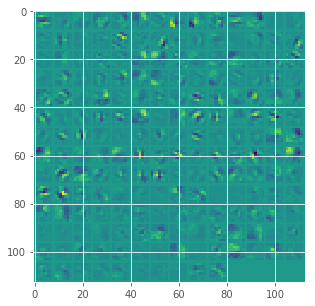

In [39]:
from libs import utils
W_montage = utils.montage_filters(W_eval)
plt.figure(figsize=(5,5))
plt.imshow(W_montage, interpolation='nearest')

- Or, we can also try to look at them as RGB filters, showing the influence of each color channel, for each neuron or output filter.

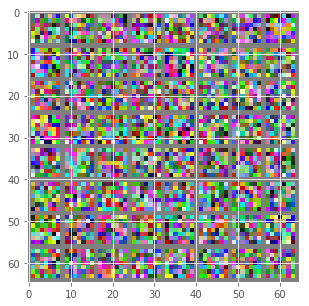

In [40]:
Ws = [utils.montage_filters(W_eval[:, :, [i], :]) for i in range(3)]
Ws = np.rollaxis(np.array(Ws), 0, 3)   ## make a 3 element list into an array
plt.figure(figsize=(5,5))
plt.imshow(Ws, interpolation='nearest')

- In order to better see what these are doing, let's normalize the filters range:

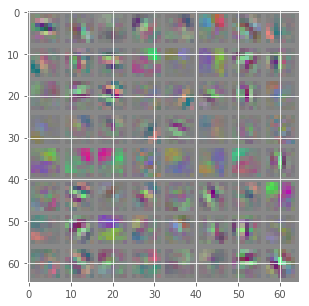

In [41]:
np.min(Ws), np.max(Ws)
Ws = (Ws / np.max(np.abs(Ws)) * 128 + 128).astype(np.uint8)
plt.figure(figsize=(5,5))
plt.imshow(Ws, interpolation='nearest')

- I actually can interprate the weights at all, this is probably not very useful to understand the process
- Now let's take a look at the output of first layer 

In [44]:
## get the output by name 
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
layer_shape = tf.shape(feature).eval(feed_dict={x:img_4d})
print(layer_shape)               ## after apply fileter, out picture became a 150X150X64 matrix

[  1 150 150  64]


So our original image which was 1 x 299 x 299 x 3 color channels, now has 64 new channels of information. The image's height and width are also halved, because of the stride of 2 in the convolution. We've just seen what each of the convolution filters look like. Let's try to see how they filter the image now by looking at the resulting convolution.

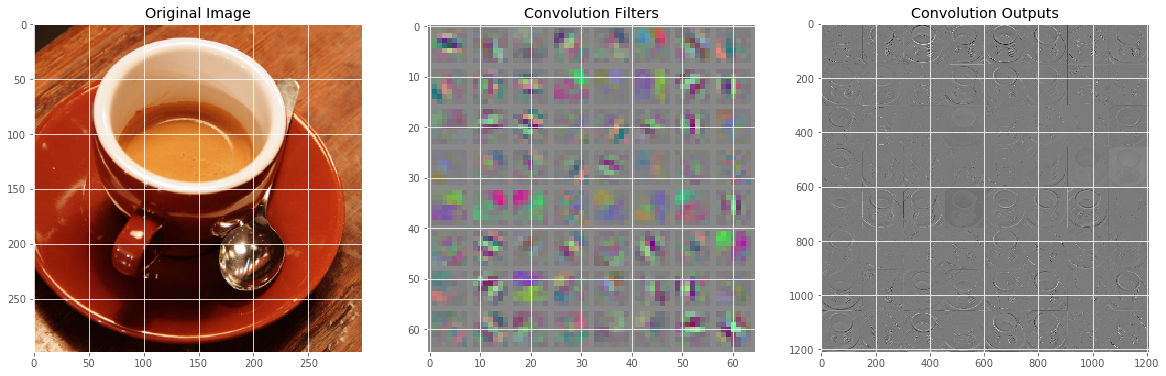

In [45]:
f = feature.eval(feed_dict={x: img_4d})
montage = utils.montage_filters(np.rollaxis(np.expand_dims(f[0], 3), 3, 2))
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(inception.deprocess(img))
axs[0].set_title('Original Image')
axs[1].imshow(Ws, interpolation='nearest')
axs[1].set_title('Convolution Filters')
axs[2].imshow(montage, cmap='gray')
axs[2].set_title('Convolution Outputs')

##### still, we are showing a higher dimention in 2d. it is actually very difficult to tell anything from this. we can see some of the edge pop out though. this is ok for first layer. but about next layer, too many dimentions, it is difficult to get sense of anything 

### Visualizing the Gradient

- instead of looking at the weights and output of convolving layer, we can take a look at the gradients.
- we can treat gradients as coefficients, see it as how much each pixel response to our data 

In [46]:
feature = g.get_tensor_by_name('inception/conv2d0_pre_relu:0')
gradient = tf.gradients(tf.reduce_max(feature, 3), x)   ## this will run forward propgation,
                                                        ## and back propgation to the original input
                                                        ## x is the original picture

When we run this network now, we will specify the gradient operation we've created, instead of the softmax layer of the network. This will run a forward prop up to the layer we asked to find the gradient with, and then run a back prop all the way to the input image.

In [49]:
res = sess.run(gradient, feed_dict={x: img_4d})[0]
res.shape

(1, 299, 299, 3)

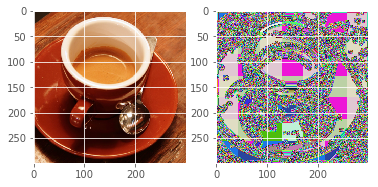

In [50]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inception.deprocess(img))
axs[1].imshow(res[0])

Well that looks like a complete mess! What we can do is normalize the activations in a way that let's us see it more in terms of the normal range of color values.

In [51]:
def normalize(img, s=0.1):
    '''Normalize the image range for visualization'''
    z = img / np.std(img)
    return np.uint8(np.clip(
        (z - z.mean()) / max(z.std(), 1e-4) * s + 0.5,
        0, 1) * 255)

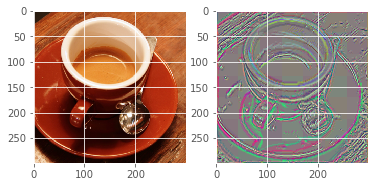

In [52]:
r = normalize(res)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(inception.deprocess(img))
axs[1].imshow(r[0])

so here, brigher pixel means higher values, you can understand it as more responsive to our data. so all the edges response more to out input data. that is how it recognize the object

- we can also take a look at each layer. we will see each layers will response to different things

In [53]:
def compute_gradient(input_placeholder, img, layer_name, neuron_i):
    feature = g.get_tensor_by_name(layer_name)
    gradient = tf.gradients(tf.reduce_mean(feature[:, :, :, neuron_i]), x)
    res = sess.run(gradient, feed_dict={input_placeholder: img})[0]
    return res

def compute_gradients(input_placeholder, img, layer_name):
    feature = g.get_tensor_by_name(layer_name)
    layer_shape = tf.shape(feature).eval(feed_dict={input_placeholder: img})
    gradients = []
    for neuron_i in range(layer_shape[-1]):
        gradients.append(compute_gradient(input_placeholder, img, layer_name, neuron_i))
    return gradients

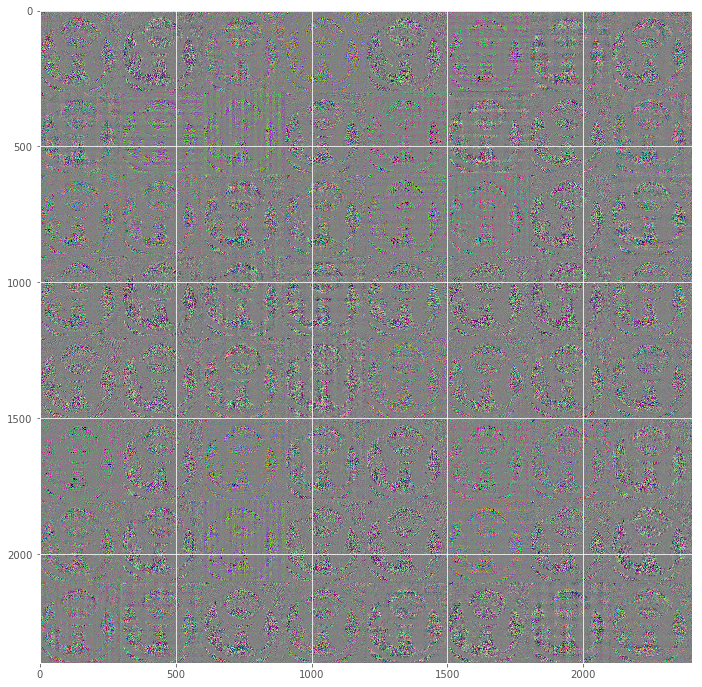

In [54]:
gradients = compute_gradients(x, img_4d, 'inception/conv2d1_pre_relu:0')
gradients_norm = [normalize(gradient_i[0]) for gradient_i in gradients]
montage = utils.montage(np.array(gradients_norm))

plt.figure(figsize=(12, 12))
plt.imshow(montage)

##### Here we can see that actually different layers response to different things, some are more interested in edges, some are more interested the liquid in the cup etc.

### Max pooling
- it is usually follows the convolving filter. it basically taking the max value of the filter window and use that as the new value. 
- we used to just sum them up, but people usually use max pooling